In [ ]:
# @title Import Library
import os, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import gc
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_fscore_support, classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight
try:
    from lightgbm import LGBMClassifier
    LGBM_AVAILABLE = True
except Exception as e:
    LGBM_AVAILABLE = False
    print("LightGBM belum terpasang.")

RANDOM_STATE = 42

In [ ]:
# @title Mount Drive and Path Configuration
from google.colab import drive
drive.mount('/content/drive/')

project_path = "/content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern"
eda_output_path = f"{project_path}/Outputs/EDA Outputs"
preproc_output_path = f"{project_path}/Outputs/Preprocessing Outputs"
os.makedirs(preproc_output_path, exist_ok=True)

Mounted at /content/drive/


In [ ]:
# @title Load Data
train_path = f"{eda_output_path}/train_merged.csv"
test_path  = f"{eda_output_path}/test_merged.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

# Display Train
print("Train shape:", train.shape)
display(train.head())

# Display Test
print("Test shape:", test.shape)
display(test.head())

# Pastikan kolom penting ada
assert 'TARGET' in train.columns, "TARGET column is missing in train dataset!"
assert 'SK_ID_CURR' in train.columns and 'SK_ID_CURR' in test.columns, "SK_ID_CURR column must exist in both train & test"

Train shape: (307511, 175)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ins_count,ins_amt_instalment_mean,ins_amt_instalment_sum,ins_amt_payment_mean,ins_amt_payment_sum,ins_pay_ratio_mean,ins_pay_ratio_max,ins_days_late_mean,ins_days_late_max,ins_late_rate
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,19.0,11559.247105,219625.695,11559.247105,219625.695,1.000000,1.0,-20.421053,-12.0,0.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,25.0,64754.586000,1618864.650,64754.586000,1618864.650,1.000000,1.0,-7.160000,-1.0,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,3.0,7096.155000,21288.465,7096.155000,21288.465,1.000000,1.0,-7.666667,-3.0,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,16.0,62947.088438,1007153.415,62947.088438,1007153.415,1.000000,1.0,-19.375000,-1.0,0.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,66.0,12666.444545,835985.340,12214.060227,806127.975,0.954545,1.0,-3.636364,12.0,0.242424


Test shape: (48744, 174)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ins_count,ins_amt_instalment_mean,ins_amt_instalment_sum,ins_amt_payment_mean,ins_amt_payment_sum,ins_pay_ratio_mean,ins_pay_ratio_max,ins_days_late_mean,ins_days_late_max,ins_late_rate
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,7.0,5885.132143,41195.925,5885.132143,41195.925,1.000000,1.0,-7.285714,11.0,0.142857
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,9.0,6240.205000,56161.845,6240.205000,56161.845,1.000000,1.0,-23.555556,1.0,0.111111
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,155.0,10897.898516,1689174.270,9740.235774,1509736.545,0.935484,1.0,-5.180645,21.0,0.070968
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,113.0,4979.282257,562658.895,4356.731549,492310.665,0.911504,1.0,-3.000000,7.0,0.106195
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,12.0,11100.337500,133204.050,11100.337500,133204.050,1.000000,1.0,-12.250000,-9.0,0.000000


# Exploratory Data Analysis (EDA)

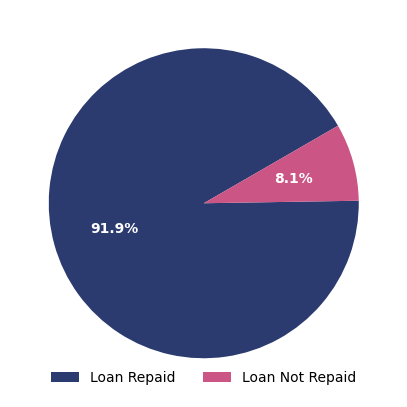

In [ ]:
# @title Data Balanced or Imbalanced
# Hitung jumlah tiap kategori TARGET
temp = train["TARGET"].value_counts()
label_map = {0: "Loan Repaid", 1: "Loan Not Repaid"}
labels = temp.index.map(label_map)
sizes = temp.values

# Warna RGB
colors = [(43/255, 58/255, 111/255), (203/255, 85/255, 132/255)]

# Plot pie chart
fig, ax = plt.subplots(figsize=(5, 5), facecolor="none")
wedges, texts, autotexts = ax.pie(sizes,
                                  labels=None,
                                  autopct='%1.1f%%',
                                  startangle=30,
                                  colors=colors,
                                  textprops={'color': "white", 'fontsize': 10, 'fontweight': 'bold'})
ax.legend(wedges, labels,
          loc="upper center",
          bbox_to_anchor=(0.5, 0.1),
          ncol=2,
          frameon=False)

fig.patch.set_alpha(0)
ax.set_facecolor("none")
plt.subplots_adjust(bottom=0)
plt.savefig("loan_pie.png", dpi=1000, transparent=True, bbox_inches="tight")
plt.show()

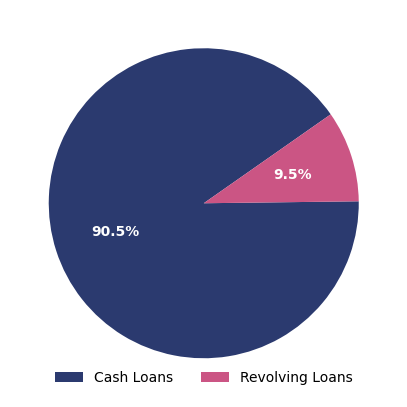

In [ ]:
# @title Types of Loan
# Hitung jumlah tiap kategori TARGET
temp = train["NAME_CONTRACT_TYPE"].value_counts()
label_map = {"Cash loans": "Cash Loans", "Revolving loans": "Revolving Loans"}
labels = temp.index.map(label_map)
sizes = temp.values

# Warna RGB
colors = [(43/255, 58/255, 111/255), (203/255, 85/255, 132/255)]

# Plot pie chart
fig, ax = plt.subplots(figsize=(5, 5), facecolor="none")
wedges, texts, autotexts = ax.pie(sizes,
                                  labels=None,
                                  autopct='%1.1f%%',
                                  startangle=35,
                                  colors=colors,
                                  textprops={'color': "white", 'fontsize': 10, 'fontweight': 'bold'})
ax.legend(wedges, labels,
          loc="upper center",
          bbox_to_anchor=(0.5, 0.1),
          ncol=2,
          frameon=False)

fig.patch.set_alpha(0)
ax.set_facecolor("none")
plt.subplots_adjust(bottom=0)
plt.savefig("loan_pie.png", dpi=1000, transparent=True, bbox_inches="tight")
plt.show()

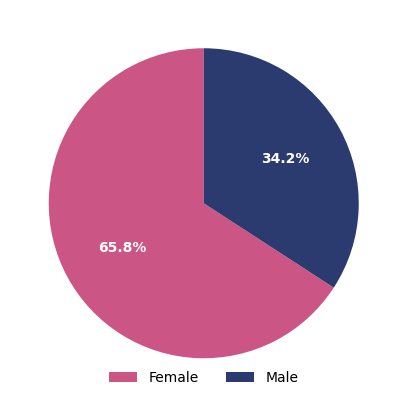

In [ ]:
# @title Applicant's Gender Pie Chart
# Hitung jumlah tiap kategori TARGET
# Ambil hanya kategori M dan F
temp = train.loc[train["CODE_GENDER"].isin(["M", "F"]), "CODE_GENDER"].value_counts()
label_map = {"F": "Female", "M": "Male"}
labels = temp.index.map(label_map)
sizes = temp.values

color_map = {"Male": (43/255, 58/255, 111/255),
             "Female": (203/255, 85/255, 132/255)}
colors = [color_map[label] for label in labels]

# Plot pie chart
fig, ax = plt.subplots(figsize=(5, 5), facecolor="none")
wedges, texts, autotexts = ax.pie(sizes,
                                  labels=None,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  colors=colors,
                                  textprops={'color': "white", 'fontsize': 10, 'fontweight': 'bold'})
ax.legend(wedges, labels,
          loc="upper center",
          bbox_to_anchor=(0.5, 0.1),
          ncol=2,
          frameon=False)

fig.patch.set_alpha(0)
ax.set_facecolor("none")
plt.subplots_adjust(bottom=0.1)
plt.savefig("gender_pie.png", dpi=1000, transparent=True, bbox_inches="tight")
plt.show()

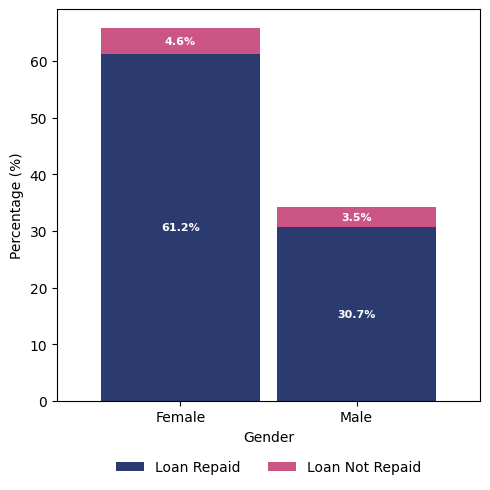

In [ ]:
# @title Applicant's Gender vs TARGET (StackBar)
ct = pd.crosstab(train.loc[train["CODE_GENDER"].isin(["M", "F"]), "CODE_GENDER"], train["TARGET"])
ct.index = ct.index.map({"M": "Male", "F": "Female"})
ct_pct_total = ct / ct.values.sum() * 100

color_map = {0: (43/255, 58/255, 111/255),   # Biru = Loan Repaid
             1: (203/255, 85/255, 132/255)}  # Pink = Loan Not Repaid

# Plot stacked bar
ax = ct_pct_total.plot(kind="bar",
                 stacked=True,
                 color=[color_map[col] for col in ct_pct_total.columns],
                 figsize=(5,5),
                 width=0.9)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:
      ax.text(x + width/2,
              y + height/2,
              f"{height:.1f}%",
              ha="center", va="center",
              fontsize=8, color="white", fontweight="bold")
ax.legend(["Loan Repaid", "Loan Not Repaid"],
         loc="upper center",
         bbox_to_anchor=(0.5, -0.12),
         ncol=2,
         frameon=False)

ax.set_facecolor("none")
ax.figure.patch.set_alpha(0)
plt.xlabel("Gender")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("gender_stack.png", dpi=1000, transparent=True)
plt.show()

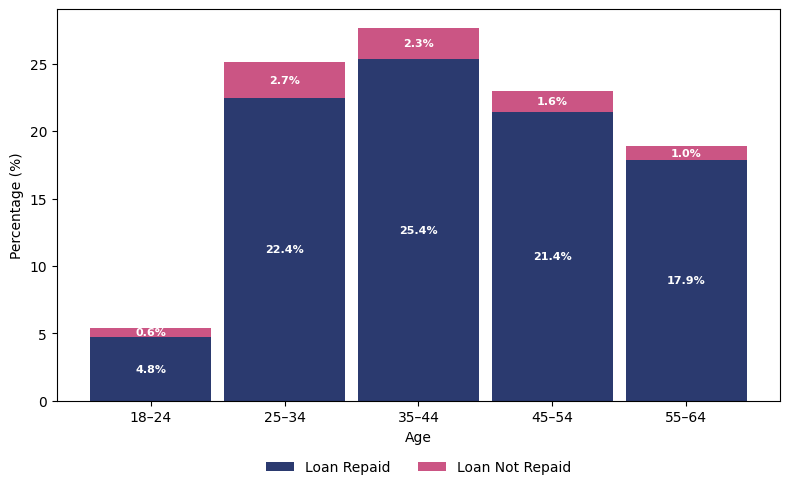

In [ ]:
# @title Applicant's Days Birth
# Konversi ke umur dalam tahun & Buat Kategori
train["AGE"] = (-train["DAYS_BIRTH"] / 365).astype(int)
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ["18–24", "25–34", "35–44", "45–54", "55–64", "65+"]
train["AGE_GROUP"] = pd.cut(train["AGE"], bins=bins, labels=labels, right=True)

ct = pd.crosstab(train["AGE_GROUP"], train["TARGET"])
ct = ct.drop("65+", errors="ignore")
ct_pct_total = ct / ct.values.sum() * 100

color_map = {0: (43/255, 58/255, 111/255),   # Biru = Loan Repaid
             1: (203/255, 85/255, 132/255)}  # Pink = Loan Not Repaid

# Plot stacked bar
ax = ct_pct_total.plot(kind="bar",
                 stacked=True,
                 color=[color_map[col] for col in ct_pct_total.columns],
                 figsize=(8,5),
                 width=0.9)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width/2,
                y + height/2,
                f"{height:.1f}%",
                ha="center", va="center",
                fontsize=8, color="white", fontweight="bold")
ax.legend(["Loan Repaid", "Loan Not Repaid"],
          loc="upper center",
          bbox_to_anchor=(0.5, -0.12),
          ncol=2,
          frameon=False)

ax.set_facecolor("none")
ax.figure.patch.set_alpha(0)
plt.xlabel("Age")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("agegroup_stack.png", dpi=1000, transparent=True)
plt.show()

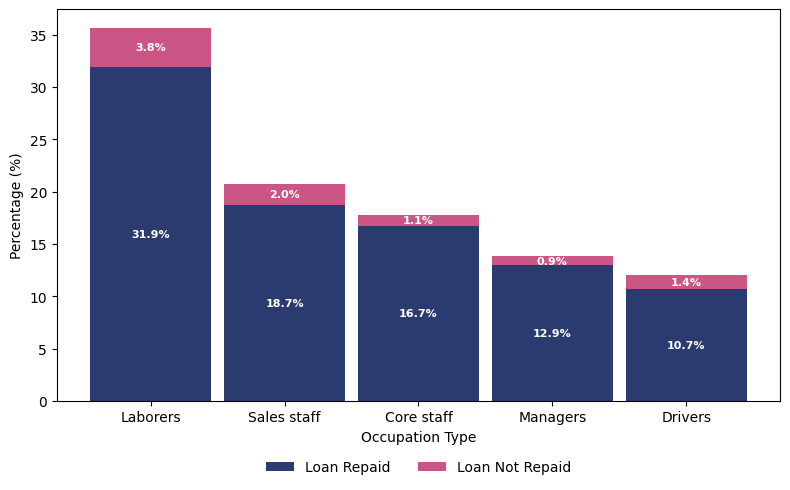

In [ ]:
# @title Applicant's Occupation
top5_occ = train["OCCUPATION_TYPE"].value_counts().nlargest(5).index
df_occ = train[train["OCCUPATION_TYPE"].isin(top5_occ)]

ct = pd.crosstab(df_occ["OCCUPATION_TYPE"], df_occ["TARGET"])
ct_pct_total = ct / ct.values.sum() * 100
ct_pct_total = ct_pct_total.loc[ct_pct_total.sum(axis=1).sort_values(ascending=False).index]

color_map = {0: (43/255, 58/255, 111/255),   # Biru = Loan Repaid
             1: (203/255, 85/255, 132/255)}  # Pink = Loan Not Repaid

ax = ct_pct_total.plot(kind="bar",
                 stacked=True,
                 color=[color_map[col] for col in ct_pct_total.columns],
                 figsize=(8,5),
                 width=0.9)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:  # biar teks 0% tidak muncul
        ax.text(x + width/2,
                y + height/2,
                f"{height:.1f}%",
                ha="center", va="center",
                fontsize=8, color="white", fontweight="bold")
ax.legend(["Loan Repaid", "Loan Not Repaid"],
          loc="upper center",
          bbox_to_anchor=(0.5, -0.12),
          ncol=2,
          frameon=False)

ax.set_facecolor("none")
ax.figure.patch.set_alpha(0)
plt.xlabel("Occupation Type")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("occupation_stack.png", dpi=1000, transparent=True)
plt.show()

# **Data Preprocessing**

In [ ]:
# @title Drop identifier columns and Separate target

# Drop identifier columns
train_proc = train.drop(columns=['SK_ID_CURR'])
test_proc  = test.drop(columns=['SK_ID_CURR'])

# Separate Target
y = train_proc['TARGET']
X = train_proc.drop(columns=['TARGET'])

# Display
print("X shape:", X.shape)
display(X.head())

print("y shape:", y.shape)
display(y.head())

print("Test_proc shape:", test_proc.shape)
display(test_proc.head())

X shape: (307511, 173)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,ins_count,ins_amt_instalment_mean,ins_amt_instalment_sum,ins_amt_payment_mean,ins_amt_payment_sum,ins_pay_ratio_mean,ins_pay_ratio_max,ins_days_late_mean,ins_days_late_max,ins_late_rate
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,19.0,11559.247105,219625.695,11559.247105,219625.695,1.000000,1.0,-20.421053,-12.0,0.000000
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,25.0,64754.586000,1618864.650,64754.586000,1618864.650,1.000000,1.0,-7.160000,-1.0,0.000000
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,3.0,7096.155000,21288.465,7096.155000,21288.465,1.000000,1.0,-7.666667,-3.0,0.000000
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,16.0,62947.088438,1007153.415,62947.088438,1007153.415,1.000000,1.0,-19.375000,-1.0,0.000000
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,66.0,12666.444545,835985.340,12214.060227,806127.975,0.954545,1.0,-3.636364,12.0,0.242424


y shape: (307511,)


,TARGET
0,1
1,0
2,0
3,0
4,0


Test_proc shape: (48744, 173)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,ins_count,ins_amt_instalment_mean,ins_amt_instalment_sum,ins_amt_payment_mean,ins_amt_payment_sum,ins_pay_ratio_mean,ins_pay_ratio_max,ins_days_late_mean,ins_days_late_max,ins_late_rate
0,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,...,7.0,5885.132143,41195.925,5885.132143,41195.925,1.000000,1.0,-7.285714,11.0,0.142857
1,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,...,9.0,6240.205000,56161.845,6240.205000,56161.845,1.000000,1.0,-23.555556,1.0,0.111111
2,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,...,155.0,10897.898516,1689174.270,9740.235774,1509736.545,0.935484,1.0,-5.180645,21.0,0.070968
3,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,...,113.0,4979.282257,562658.895,4356.731549,492310.665,0.911504,1.0,-3.000000,7.0,0.106195
4,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,...,12.0,11100.337500,133204.050,11100.337500,133204.050,1.000000,1.0,-12.250000,-9.0,0.000000


In [ ]:
# @title Check Missing Values
missing_train = X.isnull().sum()
missing_train_percent = (X.isnull().mean() * 100).sort_values(ascending=False)

missing_summary = pd.DataFrame({'Missing Values': missing_train,
                                'Percentage (%)': missing_train_percent}).sort_values(by='Percentage (%)', ascending=False)
print("Missing values in train:")
display(missing_summary.head(10))

Missing values in train:


,Missing Values,Percentage (%)
cc_util_mean,221475,72.021814
cc_util_max,221475,72.021814
cc_count,220606,71.739222
cc_amt_balance_mean,220606,71.739222
cc_amt_drawings_mean,220606,71.739222
cc_amt_total_receivable_mean,220606,71.739222
cc_amt_payment_total_mean,220606,71.739222
cc_months_balance_max,220606,71.739222
cc_months_balance_min,220606,71.739222
cc_amt_payment_total_max,220606,71.739222


In [ ]:
# @title Imputation Missing Values
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

X[num_cols] = num_imputer.fit_transform(X[num_cols])
test_proc[num_cols] = num_imputer.transform(test_proc[num_cols])
if len(cat_cols) > 0:
  X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])
  test_proc[cat_cols] = cat_imputer.transform(test_proc[cat_cols])

# Cek sisa missing values
print("Missing values after imputation (Train):", X.isnull().sum().sum())
print("Missing values after imputation (Test) :", test_proc.isnull().sum().sum())
print("✅ Missing values handled")

Missing values after imputation (Train): 0
Missing values after imputation (Test) : 0
✅ Missing values handled


In [ ]:
# @title Encoding Categorical
if len(cat_cols) > 0:
    cat_cols = [c for c in cat_cols if c in X.columns and c in test_proc.columns]
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_cat = ohe.fit_transform(X[cat_cols])
    test_cat = ohe.transform(test_proc[cat_cols])
    X_cat = pd.DataFrame(X_cat, columns=ohe.get_feature_names_out(cat_cols), index=X.index)
    test_cat = pd.DataFrame(test_cat, columns=ohe.get_feature_names_out(cat_cols), index=test_proc.index)

    # gabungkan kembali numeric + categorical encoded
    X_noscale = pd.concat([X[num_cols], X_cat], axis=1)
    test_noscale = pd.concat([test_proc[num_cols], test_cat], axis=1)
else:
    X_noscale = X.copy()
    test_noscale = test_proc.copy()

print("Train encoded sample:")
display(X_noscale.head())
print("\nTest encoded sample:")
display(test_noscale.head())
print("✅ Encoding selesai. Final shape:", X_noscale.shape, test_noscale.shape)

Train encoded sample:


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0



Test encoded sample:


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241.0,-2329.0,-5170.0,-812.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064.0,-4469.0,-9118.0,-1623.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038.0,-4458.0,-2175.0,-3503.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2.0,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976.0,-1866.0,-2000.0,-4208.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,180000.0,625500.0,32067.0,625500.0,0.010032,-13040.0,-2191.0,-4000.0,-4262.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


✅ Encoding selesai. Final shape: (307511, 297) (48744, 297)


In [ ]:
# @title Scaling
scaler = StandardScaler()
X_scaled = X_noscale.copy()
test_scaled = test_noscale.copy()
X_scaled[num_cols] = scaler.fit_transform(X_noscale[num_cols])
test_scaled[num_cols] = scaler.transform(test_noscale[num_cols])

print("✅ Scaling selesai.")
print("Train scaled shape:", X_scaled.shape)
print("Test scaled shape :", test_scaled.shape)

print("\n📌 Sample scaled numerical features (Train):")
display(X_scaled[num_cols].head())
print("\n📌 Sample scaled numerical features (Test):")
display(test_scaled[num_cols].head())

✅ Scaling selesai.
Train scaled shape: (307511, 297)
Test scaled shape : (48744, 297)

📌 Sample scaled numerical features (Train):


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ins_count,ins_amt_instalment_mean,ins_amt_instalment_sum,ins_amt_payment_mean,ins_amt_payment_sum,ins_pay_ratio_mean,ins_pay_ratio_max,ins_days_late_mean,ins_days_late_max,ins_late_rate
0,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,-0.502039,-0.286987,-0.505590,-0.280018,-0.491631,-0.012358,-0.013871,-0.726342,-0.253549,-0.640579
1,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,-0.351313,2.049805,1.120573,1.891991,1.070434,-0.012358,-0.013871,0.308805,-0.151926,-0.640579
2,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,-0.903973,-0.483044,-0.736093,-0.462250,-0.713049,-0.012358,-0.013871,0.269255,-0.170403,-0.640579
3,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,-0.577401,1.970404,0.409656,1.818189,0.387539,-0.012358,-0.013871,-0.644688,-0.151926,-0.640579
4,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,0.678642,-0.238349,0.210729,-0.253282,0.163121,-0.013905,-0.013871,0.583857,-0.031826,1.491480



📌 Sample scaled numerical features (Test):


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ins_count,ins_amt_instalment_mean,ins_amt_instalment_sum,ins_amt_payment_mean,ins_amt_payment_sum,ins_pay_ratio_mean,ins_pay_ratio_max,ins_days_late_mean,ins_days_late_max,ins_late_rate
0,-0.577538,-0.142533,-0.075097,-0.451790,-0.239153,-0.145910,-0.734193,-0.468192,-0.052196,1.445696,...,-0.803489,-0.536242,-0.712957,-0.511697,-0.690825,-0.012358,-0.013871,0.298992,-0.041064,0.615813
1,-0.577538,-0.294354,-0.934825,-0.671924,-0.970289,1.078997,-0.464485,-0.483339,-1.172870,0.908413,...,-0.753247,-0.520645,-0.695564,-0.497199,-0.674117,-0.012358,-0.013871,-0.971018,-0.133449,0.336615
2,-0.577538,0.142129,0.159601,2.943988,0.248271,-0.127762,-0.916824,-0.483262,0.797961,-0.337075,...,2.914400,-0.316039,1.202285,-0.354290,0.948606,-0.014553,-0.013871,0.463311,0.051321,-0.016436
3,2.192084,0.616567,2.424840,1.511720,2.807247,0.399377,0.472274,-0.464915,0.847636,-0.804133,...,1.859324,-0.576035,-0.106925,-0.574103,-0.187215,-0.015369,-0.013871,0.633531,-0.078018,0.293376
4,0.807273,0.047242,0.065776,0.342121,0.236086,-0.783451,0.686757,-0.467215,0.279919,-0.839908,...,-0.677885,-0.307146,-0.606027,-0.298756,-0.588110,-0.012358,-0.013871,-0.088516,-0.225834,-0.640579


In [ ]:
print("Train scaled sample (full):")
display(X_scaled.head())

print("Test scaled sample (full):")
display(test_scaled.head())

Train scaled sample (full):


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Test scaled sample (full):


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,-0.577538,-0.142533,-0.075097,-0.451790,-0.239153,-0.145910,-0.734193,-0.468192,-0.052196,1.445696,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.577538,-0.294354,-0.934825,-0.671924,-0.970289,1.078997,-0.464485,-0.483339,-1.172870,0.908413,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.577538,0.142129,0.159601,2.943988,0.248271,-0.127762,-0.916824,-0.483262,0.797961,-0.337075,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2.192084,0.616567,2.424840,1.511720,2.807247,0.399377,0.472274,-0.464915,0.847636,-0.804133,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.807273,0.047242,0.065776,0.342121,0.236086,-0.783451,0.686757,-0.467215,0.279919,-0.839908,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# @title Save to CSV

# Without Scaling
train_noscale = X_noscale.copy()
train_noscale['TARGET'] = y.values
train_noscale.to_csv(f"{preproc_output_path}/train_noscale.csv", index=False)
test_noscale.to_csv(f"{preproc_output_path}/test_noscale.csv", index=False)

# With Scaling
train_scaled = X_scaled.copy()
train_scaled['TARGET'] = y.values
train_scaled.to_csv(f"{preproc_output_path}/train_scaled.csv", index=False)
test_scaled.to_csv(f"{preproc_output_path}/test_scaled.csv", index=False)

In [ ]:
print("Train (no scale):", train_noscale.shape)
print("Test  (no scale):", test_noscale.shape)
print("Train (scaled)  :", train_scaled.shape)
print("Test  (scaled)  :", test_scaled.shape)

Train (no scale): (307511, 298)
Test  (no scale): (48744, 297)
Train (scaled)  : (307511, 298)
Test  (scaled)  : (48744, 297)


# **Feature Selection**

## Random Forest

In [ ]:
# @title Load Dataset
train_noscale = pd.read_csv(os.path.join(preproc_output_path, "train_noscale.csv"))
print("Train No Scaled:", train_noscale.shape)

Train No Scaled: (307511, 298)


In [ ]:
# @title Separated TARGET and Feature Columns
target_col = 'TARGET'
X_noscale = train_noscale.drop(columns=[target_col])
y_noscale = train_noscale[target_col]
print("X_noscale:", X_noscale.shape)
print("y_noscale:", y_noscale.shape)

X_noscale: (307511, 297)
y_noscale: (307511,)


In [ ]:
# @title Random Forest Feature Selection
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            max_features='sqrt',
                            n_jobs=-1,
                            random_state=42)
rf.fit(X_noscale, y_noscale)

# Feature selection
sfm_rf = SelectFromModel(rf, prefit=True, threshold='median')  # pilih fitur penting >= median importance
selected_features_rf = X_noscale.columns[sfm_rf.get_support()]
print("✅ Fitur terpilih oleh Random Forest:")
print(selected_features_rf.tolist())
print(f"\nJumlah fitur terpilih: {len(selected_features_rf)} dari total {X_noscale.shape[1]} fitur")

✅ Fitur terpilih oleh Random Forest:
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MO

In [ ]:
# Ambil dataset hasil feature selection Random Forest
X_train_rf = X_noscale[selected_features_rf].copy()
X_train_rf['TARGET'] = y_noscale.values
X_test_rf = test_noscale[selected_features_rf].copy()

X_train_rf.to_csv(f"{preproc_output_path}/train_selected_noscale.csv", index=False)
X_test_rf.to_csv(f"{preproc_output_path}/test_selected_noscale.csv", index=False)

print("✅ Dataset hasil feature selection Random Forest berhasil disimpan.")
print("Train RF shape:", X_train_rf.shape)
print("Test RF shape :", X_test_rf.shape)

✅ Dataset hasil feature selection Random Forest berhasil disimpan.
Train RF shape: (307511, 150)
Test RF shape : (48744, 149)


In [ ]:
# @title Scaling Feature Selection
num_cols_rf = [col for col in selected_features_rf if col in num_cols]
X_train_rf_scaled = X_train_rf.copy()
X_test_rf_scaled = X_test_rf.copy()

scaler = StandardScaler()
X_train_rf_scaled[num_cols_rf] = scaler.fit_transform(X_train_rf[num_cols_rf])
X_test_rf_scaled[num_cols_rf] = scaler.transform(X_test_rf[num_cols_rf])

print("Train RF Scaled shape:", X_train_rf_scaled.shape)
print("Test RF Scaled shape :", X_test_rf_scaled.shape)
print("Jumlah kolom numeric yg discale:", len(num_cols_rf))

X_train_rf_scaled.to_csv(f"{preproc_output_path}/train_selected_scaled.csv", index=False)
X_test_rf_scaled.to_csv(f"{preproc_output_path}/test_selected_scaled.csv", index=False)

Train RF Scaled shape: (307511, 150)
Test RF Scaled shape : (48744, 149)
Jumlah kolom numeric yg discale: 121
